In [9]:
import tkinter as tk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import pandas as pd
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import numpy as np
import time
import requests
import json
import os
from threading import Thread
from tkinter import filedialog, messagebox
from matplotlib.figure import Figure
import time
from matplotlib.animation import FuncAnimation

In [10]:
#Глобальные постоянные
is_running = False
file_index = 10
file_name = None
df = None

In [11]:
#функция остановки записи
def stop_data_process():
    global is_running
    is_running = False
    global file_index 
    file_index += 1
    messagebox.showinfo("Информация", "Запись данных остановлена.")


In [12]:
#Подготовка данных к предсказаниям

def prepare_and_visualize_data(df, visualize=True):
    TOTAL = df.shape[0]
    TRAIN_VAL = int(TOTAL * 0.5)
    VAL_TEST = int(TOTAL * 0.7)

    my_scaler = MinMaxScaler()
    df_scaled = my_scaler.fit_transform(df)
    df = pd.DataFrame(df_scaled, columns=df.columns)
    train_df = df[:TRAIN_VAL]
    val_df = df[TRAIN_VAL:VAL_TEST]
    test_df = df[VAL_TEST:]

    if visualize:
        df_std = df.melt(var_name='Column', value_name='Normalized')
        # Clear the previous plot on the main figure
        ax.clear() 
        sns.violinplot(x='Column', y='Normalized', data=df_std, ax=ax)
        
        # Set the tick positions before setting labels
        ax.set_xticks(range(len(df.columns)))  
        ax.set_xticklabels(df.columns, rotation=90)

    canvas.draw()  # Redraw the main figure with the updated plot

    return train_df, val_df, test_df

In [13]:
#функция считывает названия параметров из файла и приводит в вид для считывания
def process_excel_headers(excel_file):
  df = pd.read_csv(excel_file)
  fileheaders = list(df.columns)
  fileheaders  = [header.lower() for header in fileheaders]
  headerskey = fileheaders[0:14]
  updated_list = [ item for item in headerskey]
  jsonstring = str(updated_list)
  jsonstring = jsonstring.replace("'", '"')    
  return df, fileheaders, jsonstring

excel_file = 'data_8_without_duplicates.csv'
dk, fileheaders, jsonstring = process_excel_headers(excel_file)

In [14]:
#Загрузка и обработка файла

def downloadfile():
    """Загружает CSV-файл с устройства."""
    global file_name
    file_name= filedialog.askopenfilename(
        defaultextension=".csv",
        filetypes=[("CSV files", "*.csv"), ("All files", "*.*")]
    )

    if file_name:
        try:
            global df
            global jsonstring  # Declare df as global to make it accessible from other functions
            df, fileheaders, jsonstring = process_excel_headers(file_name)
            btn2.config(state=tk.NORMAL)
            messagebox.showinfo("Успешно", "Файл успешно загружен!")
        except Exception as e:
            messagebox.showerror("Ошибка", f"Ошибка при загрузке файла: {e}")
    else:
        messagebox.showinfo("Отмена", "Загрузка файла отменена")


In [42]:
#функция построения графика
def plot_graph():
    df = pd.read_csv('data_8_without_duplicates.csv')
    if 'DateTime' not in df.columns:
        messagebox.showinfo("Секунду", "Обрабатываем файл")
        df.columns = list(df.columns) + ['DateTime']

    df.to_csv('data_8_without_duplicates.csv', index=False) 
    df['DateTime'] = pd.to_datetime(df['DateTime'], infer_datetime_format=True)

    df.set_index('DateTime')[['ssx10mag10cp930','ssx10pab20ct001','ssx10pab10ct001','ssxtg_2ce003',
                               'ssx10lca10ct001','ssx10pab10cf001','ssx10lbg11cp920','ssx10lbg40cp920',
                               'ssx10pab60ct001','ssx10pab30ct001','ssx10maa01cp001','ssx10lca20cf001',
                               'ssx10maa01ct001','ssx10pab30cf001']].plot(subplots=True, ax=axs.flatten(), sharex=True,  fontsize=6)
    plt.show()


In [69]:
# Функция построения графика
def plot_graph():
    df = pd.read_csv('data_8_without_duplicates.csv')
    if 'DateTime' not in df.columns:
        messagebox.showinfo("Секунду", "Обрабатываем файл")
        df.columns = list(df.columns) + ['DateTime']
    df.to_csv('data_8_without_duplicates.csv', index=False)
    df['DateTime'] = pd.to_datetime(df['DateTime'], infer_datetime_format=True)
    df.set_index('DateTime')[['ssx10mag10cp930']].plot(ax=axs, sharex=True, fontsize=6)  
    canvas.draw() # Перерисовка графика

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time

def draw_graphs(file_name= 'data_8_without_duplicates.csv'):
    try:
     df = pd.read_csv(file_name)
     df.set_index('DateTime')[['ssx10mag10cp930','ssx10pab20ct001','ssx10pab10ct001','ssxtg_2ce003','ssx10lca10ct001','ssx10pab10cf001','ssx10lbg11cp920','ssx10lbg40cp920','ssx10pab60ct001','ssx10pab30ct001','ssx10maa01cp001','ssx10lca20cf001','ssx10maa01ct001','ssx10pab30cf001']]
     if 'DateTime' in df.columns:
        date_time = pd.to_datetime(df.pop('DateTime'), infer_datetime_format=True)
        df.index = date_time
     else:
        print("Столбец 'DateTime' отсутствует в датафрейме.")
        return
     fig, axs = plt.subplots(len(df.columns), 1, sharex=True)
     fig.set_size_inches(8, 16)
     lines = []
     for i, column in enumerate(df.columns[:]):
        ax = axs[i]
        ax.figure.set_figheight(10)  # Высота каждого подграфика
        ax.figure.set_figwidth(6)  # Ширина каждого подграфика
        line, = ax.plot([], [], label=column)
        lines.append(line)
        #ax.set_ylabel(column)
        ax.legend()
        ax.tick_params(axis='x', labelrotation=45)

     for ax in axs:
        ax.grid(True)
        ax.set_xlabel('DateTime')

     def animate(i):
        # Получение последних данных
        last_data = df.index[i]
        print(f"Последние данные: {last_data}")

        # Обновление графика
        for j, line in enumerate(lines):
            column = df.columns[j]
            line.set_data(df.index[:i+1].values, df[column][:i+1])
            axs[j].set_ylim(df[column].min(), df[column].max())
            axs[j].set_xlim(df.index[0], df.index[i+1])

        # Дополнительная пауза для отображения обновления
        plt.pause(1)  # Пауза на 10 миллисекунд
        return lines

     ani = FuncAnimation(fig, animate, frames=len(df), interval=1, blit=False)
     plt.show()
    except FileNotFoundError:
        print(f"Файл '{file_name}' не найден.")

def plot_graph(file_name='data_8_without_duplicates.csv'):
    draw_graphs(file_name)
#draw_graphs()
 

In [15]:
#функции считывания переменных и создания переменных
vardict = {}
def fetch_dataz(url, prt_id, headers, string):
    global vardict
    prtData_GET = requests.get(url + '/JIS/prtData/' + prt_id, headers=headers)
    if prtData_GET.status_code == 200:
        resp = json.loads(prtData_GET.text)
        if not vardict:
             vardict = resp
        state = list(resp['variables'].values())
        print(state)
        return state
    return None

def create_new_csv_filez(file_index, string):
    global file
    file_name = f'cached_data_{file_index}.csv'
    ds = pd.DataFrame(columns=json.loads(string))
    ds.to_csv(file_name, index=False)
    print(f"Created new file: {file_name}")
    return file_name

In [16]:
def writerz(url, headers, string):
    column_names = json.loads(string)
    prtData_POST = requests.post(url + '/JIS/prtData',
                                 data=json.dumps({"variables": json.loads(string)}),
                                 headers=headers)
    if prtData_POST.status_code == 201:
        prt_id = prtData_POST.text.strip()
        print(f"prt_id: {prt_id}")

        global file_index
        file_index = file_index
        file_name = create_new_csv_filez(file_index, string)
        buffer = []

        while is_running:

            data = fetch_dataz(url, prt_id, headers,string)
            if data:
                buffer.append(data)
# Запись данных в текущий CSV файл
            ds = pd.DataFrame(buffer,columns=column_names)  
            ds['timestamp'] = pd.to_datetime('now', format='%Y-%m-%d %H:%M:%S') 
            ds.to_csv(file_name, mode='a', header=False, index=False)
            time.sleep(0.7)
            print("Uploaded successfully")
# Проверка размера файла и создание нового, если размер превышает 10 МБ            
            if os.path.getsize(file_name) > 10 * 1024 * 1024:  # 10 MB
                    file_index += 1
                    file_name = create_new_csv_filez(file_index, string)

                
# Читска буфера
            buffer = []

In [17]:
#функция начала записи
def start_data_process():
   
    global is_running
    is_running = True
    url = 'http://10.176.1.43:8190'
    auth_POST = requests.post(url + '/JIS/users/login',
                             data='{"username": "instructor", "password": ""}',
                             headers={'Content-type': 'application/json'})
    API_TOKEN = json.loads(auth_POST.text)['accessToken']
    print(API_TOKEN)
    headers = {'Authorization': f'Bearer {API_TOKEN}',
           'Content-type': 'application/json'}    
    Thread(target=plot_data, args=(url, headers, jsonstring), daemon=True).start()    
    Thread(target=writerz, args=(url, headers, jsonstring), daemon=True).start()
    # Теперь вы можете использовать GUI без блокировки основного потока
    messagebox.showinfo("Информация", "Запись данных начата.")


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\tkinter\__init__.py", line 1968, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\PC\AppData\Local\Temp\ipykernel_1512\3552206689.py", line 19, in <lambda>
    plot_button = tk.Button(root, text="Draw Grafics", command=lambda: plot_graph(file_name), font=button_font, width=15, height=2)
                                                                       ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\PC\AppData\Local\Temp\ipykernel_1512\1976920018.py", line 55, in plot_graph
    draw_graphs(file_name)
  File "C:\Users\PC\AppData\Local\Temp\ipykernel_1512\1976920018.py", line 8, in draw_graphs
    df = pd.read_csv(file_name)
         ^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\io\parsers\readers.py", line 1026, in read_csv
    return _read(filepath_or_buffer, kwds)
  

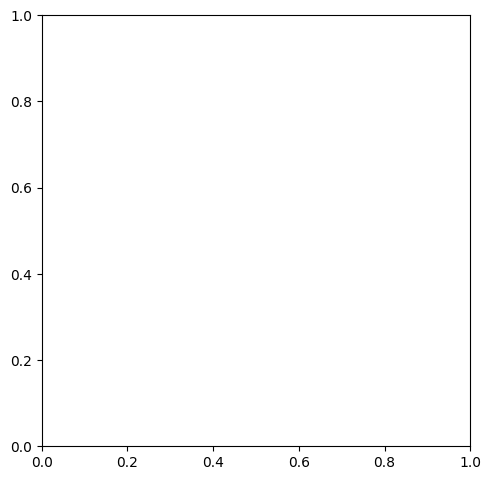

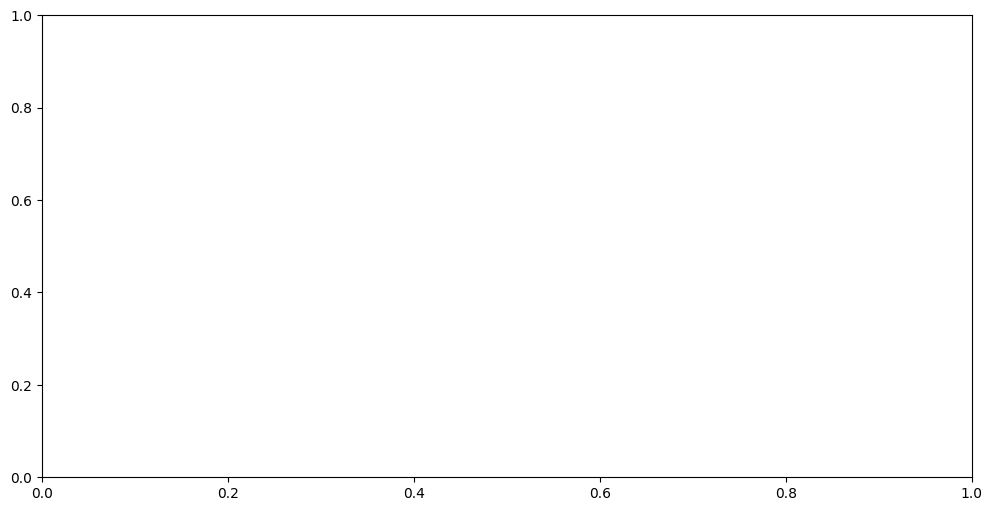

In [22]:
#UI окно
# Создаем главное окно
root = tk.Tk()
root.title("Простой интерфейс")
root.geometry("800x600")

# Настраиваем шрифт для кнопок
button_font = ("Times New Roman", 6)

# Добавьте кнопку для остановки записи данных
btn_stop = tk.Button(root, text="Stop Data Recording", command=stop_data_process, font=button_font, width=15, height=2)
btn_stop.pack(side=tk.LEFT, padx=10, pady=5)

# Создаем  кнопки с одинаковым размером
btn1 = tk.Button(root, text="Download dataset", command=lambda: downloadfile(), font=button_font, width=12, height=2)
btn2 = tk.Button(root, text="Normalize data", command=lambda: prepare_and_visualize_data(df), font=button_font, width=12, height=2)
btn3 = tk.Button(root, text="Start Data Recording", command=start_data_process, font=button_font, width=15, height=2)
# Кнопка для построения графика
plot_button = tk.Button(root, text="Draw Grafics", command=lambda: plot_graph(file_name), font=button_font, width=15, height=2)
plot_button.pack(side=tk.LEFT, padx=10, pady=5)
# Размещаем кнопки в левом краю друг под другом с отступами
btn1.pack(side=tk.LEFT, padx=10, pady=5)
btn2.pack(side=tk.LEFT, padx=10, pady=5)
btn3.pack(side=tk.LEFT, padx=10, pady=5)

# Создаем рамку для разделения кнопок и графиков
frame = tk.Frame(root)
frame.pack(side=tk.TOP, padx=10, pady=10)

# Создаем два графика

fig, axs = plt.subplots(figsize=(12, 6))  # Создаем фигуру для графика
canvas = FigureCanvasTkAgg(fig, frame)
canvas.get_tk_widget().pack(side=tk.LEFT, padx=10, pady=10)

# Создаем вторую фигуру
fign = plt.figure(figsize=(12, 6))
ax = fign.add_subplot(111) 
# Create the canvas for the main figure
canvas = FigureCanvasTkAgg(fign, frame)
canvas.get_tk_widget().pack(side=tk.LEFT, padx=10, pady=10)

root.mainloop()




NameError: name 'frame' is not defined

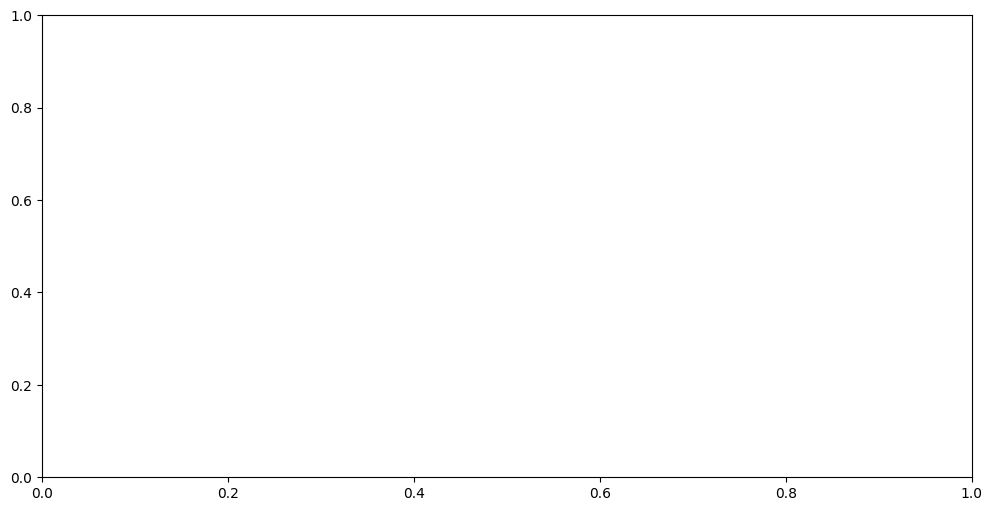

In [6]:
#функция построения графика
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg


figv, axs = plt.subplots(figsize=(12, 6))  # Изменили размер и количество графиков
canvas = FigureCanvasTkAgg(figv, frame)
canvas.get_tk_widget().pack(side=tk.LEFT, padx=10, pady=10)



def plot_graph():
    df = pd.read_csv('data_8_without_duplicates.csv')
    if 'DateTime' not in df.columns:
        messagebox.showinfo("Секунду", "Обрабатываем файл")
        df.columns = list(df.columns) + ['DateTime']

    df.to_csv('data_8_without_duplicates.csv', index=False) 
    df['DateTime'] = pd.to_datetime(df['DateTime'], infer_datetime_format=True)

    df.set_index('DateTime')[['ssx10mag10cp930','ssx10pab20ct001','ssx10pab10ct001','ssxtg_2ce003',
                               'ssx10lca10ct001','ssx10pab10cf001','ssx10lbg11cp920','ssx10lbg40cp920',
                               'ssx10pab60ct001','ssx10pab30ct001','ssx10maa01cp001','ssx10lca20cf001',
                               'ssx10maa01ct001','ssx10pab30cf001']].plot(subplots=True, ax=axs.flatten(), sharex=True,  fontsize=6)
    plt.show()


plot_graph()

In [25]:

import pickle
lstm_model_file = "lstm_model_prediction.pkl"
# load model from pickle file
with open(lstm_model_file, 'rb') as file:  
    model = pickle.load(file)



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        46,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 336)            │        33,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 24, 14)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 239,810 (936.76 KB)

 Trainable params: 79,936 (312.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 159,874 (624.51 KB)

None
[<LSTM name=lstm, built=True>, <Dropout name=dropout, built=True>, <Dense name=dense, built=True>, <Reshape name=reshape, built=True>]
[<KerasVariable shape=(14, 400), dtype=float32, path=lstm/lstm_cell/kernel>, <KerasVariable shape=(100, 400), dtype=float32, path=lstm/lstm_cell/recurrent_kernel>, <KerasVariable shape=(400,), dtype=float32, path=lstm/lstm_cell/bias>, <KerasVariable shape=(100, 336), dtype=float32, path=dense/kernel>, <KerasVariable shape=(336,), dtype=float32, path=dense/bias>]
(None, 72, 14)
(None, 24, 14)
[<Mean name=loss>, <CompileMetrics name=compile_metrics>]
